Description des entreprises qui divulguent / ne divulguent pas leurs données de gender pay gap

In [1]:
!pip install openpyxl


In [2]:
import pandas as pd
import numpy as np
import math
import openpyxl


In [3]:
file_imp_path = "data/ESG_raw_data_07_02.xlsx"
file_sect = "data/secteurs.csv"
corresp_secteurs = pd.read_csv(file_sect, sep=";")
imp_data = pd.read_excel(file_imp_path)
imp_data = imp_data.join(corresp_secteurs.set_index('primary_industry'), on = "primary_industry")

# Premières stats desc

In [4]:
data_size = imp_data.shape

print("Size of the DataFrame:")
print("Nombre d'observations:", data_size[0])
print("Nombre d'entreprises", imp_data['company_id'].nunique())
print("Nombre moyen d'employés :", imp_data['employees'].mean())

variable_list = imp_data.columns.tolist()
# Display the list of variables
print("List of Variables:")
print(variable_list)

Size of the DataFrame:
Nombre d'observations: 40554
Nombre d'entreprises 13518
Nombre moyen d'employés : 13142.447727480847
List of Variables:
['company_id', 'year', 'company_name', 'ticker', 'LEI', 'isin', 'Business Desc.', 'region', 'hq_country', 'primary_industry', 'market_cap', 'employees', 'revenue', 'scope_1', 'scope_2', 'scope_3', 'waste_production', 'waste_recycling', 'water_consumption', 'water_withdrawal', 'energy_consumption', 'hours_of_training', 'independent_board_members_percentage', 'legal_costs_paid_for_controversies', 'ceo_compensation', 'gender_pay_gap', 'secteur']


In [5]:
statistics_employees = imp_data['employees'].describe()

# Extraire les quartiles et la médiane
quartiles = [statistics_employees['25%'], statistics_employees['50%'], statistics_employees['75%']]
median = statistics_employees['50%']

# Afficher les quartiles et la médiane
print("Quartiles de la base imp_data['employees'] :")
print("Premier quartile (Q1) :", quartiles[0])
print("Médiane (Q2) :", median)
print("Troisième quartile (Q3) :", quartiles[2])

# Trouver les valeurs extrêmes de la colonne "employees"
min_employees = imp_data['employees'].min()
max_employees = imp_data['employees'].max()
print("Valeur minimale de la base imp_data['employees'] :", min_employees)
print("Valeur maximale de la base imp_data['employees'] :", max_employees)

quantile_99 = imp_data['employees'].quantile(0.99)
print("Quantile 99 de la base imp_data['employees'] :", quantile_99)

quantile_05 = imp_data['employees'].quantile(0.05)
print("Quantile 01 de la base imp_data['employees'] :", quantile_05)


Quartiles de la base imp_data['employees'] :
Premier quartile (Q1) : 1035.0
Médiane (Q2) : 3049.0
Troisième quartile (Q3) : 9362.0
Valeur minimale de la base imp_data['employees'] : 1.0
Valeur maximale de la base imp_data['employees'] : 2300000.0
Quantile 99 de la base imp_data['employees'] : 184575.20000000022
Quantile 01 de la base imp_data['employees'] : 192.0


In [6]:
# Create a table with the % of observations per region 

region_counts = imp_data['region'].value_counts(normalize=True) * 100

# Create a DataFrame from the value counts
region_percentage = pd.DataFrame({'Region': region_counts.index, '% of Observations': region_counts.values})

# Display the DataFrame
print(region_percentage)

                        Region  % of Observations
0               Asia / Pacific          59.890516
1     United States and Canada          19.751443
2                       Europe          13.729842
3         Africa / Middle East           3.491641
4  Latin America and Caribbean           3.136559


In [7]:
# Create a table with the % of observations per country 

region_counts = imp_data['hq_country'].value_counts(normalize=True) * 100

# Create a DataFrame from the value counts
region_percentage = pd.DataFrame({'Pays': region_counts.index, '% of Observations': region_counts.values})

# Display the DataFrame
print(region_percentage)

                       Pays  % of Observations
0                     China          31.143660
1             United States          17.465601
2                     Japan           7.767421
3                     India           4.793609
4                    Taiwan           3.388075
..                      ...                ...
97                  Bahamas           0.007398
98                 Bulgaria           0.007398
99                Gibraltar           0.007398
100  British Virgin Islands           0.007398
101                 Ukraine           0.007398

[102 rows x 2 columns]


In [8]:
# Create a table with the % of observations per sector 

region_counts = imp_data['secteur'].value_counts(normalize=True) * 100

# Create a DataFrame from the value counts
region_percentage = pd.DataFrame({'Secteur': region_counts.index, '% of Observations': region_counts.values})

# Display the DataFrame
print(region_percentage)

                                       Secteur  % of Observations
0                       Information Technology          12.856931
1                   Industrials, capital goods          12.575825
2                                    Materials          11.577156
3                       Consumer Discretionary          10.948365
4                                   Financials          10.933570
5                                  Health Care           9.720373
6                             Consumer Staples           8.477585
7   Industrials, commercial and transportation           7.663856
8                       Communication Services           4.438526
9                                  Real Estate           3.935493
10                                      Energy           3.484243
11                                   Utilities           3.388075


In [9]:
materials_data = imp_data[imp_data['secteur'] == 'Materials']

# Compter le nombre d'entreprises pour chaque industrie principale
industry_counts = materials_data['primary_industry'].value_counts()

# Afficher les résultats
print("Primary Industry Counts in the Materials Sector:")
print(industry_counts)

Primary Industry Counts in the Materials Sector:
primary_industry
Commodity Chemicals                       1068
Specialty Chemicals                        717
Steel                                      603
Construction Materials                     420
Diversified Metals and Mining              384
Fertilizers and Agricultural Chemicals     345
Gold                                       207
Aluminum                                   171
Paper Products                             156
Metal and Glass Containers                 132
Paper Packaging                            129
Diversified Chemicals                      117
Copper                                      75
Forest Products                             66
Industrial Gases                            42
Precious Metals and Minerals                39
Silver                                      24
Name: count, dtype: int64


In [10]:
imp_data['missing'] = imp_data['gender_pay_gap'].isnull().astype(float)

missing_paygap_subdataset = imp_data[imp_data['missing'] == 1]
non_missing_paygap_subdataset = imp_data[imp_data['missing'] == 0]


data_size = non_missing_paygap_subdataset.shape
#405 observations dans la base non_missing sur 40K 
print("Size of the DataFrame:")
print("Number of rows:", data_size[0])
print("Number of columns:", data_size[1])


Size of the DataFrame:
Number of rows: 405
Number of columns: 28


# Secteurs de prédilection

In [19]:
# Catégorisation en 12 secteurs
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest



# Group by 'secteur' and count occurrences in each dataset
missing_counts = missing_paygap_subdataset['secteur'].value_counts().head(10)
non_missing_counts = non_missing_paygap_subdataset['secteur'].value_counts().head(10)

# Calculate percentages for each dataset
missing_percentages = (missing_counts / missing_counts.sum()) * 100
non_missing_percentages = (non_missing_counts / non_missing_counts.sum()) * 100

# Display the top 10 sectors in each dataset along with their percentages
print("Top 10 Sectors in Missing Pay Gap Subdataset:")
print(missing_counts)

print("\nTop 10 Sectors in Non-Missing Pay Gap Subdataset:")
print(non_missing_counts)

unique_sectors = missing_paygap_subdataset['secteur'].unique()
# Perform Z-tests for each sector
z_test_results = {}
for sector in unique_sectors:
    # Get counts for the current sector in both datasets
    missing_count = missing_paygap_subdataset['secteur'].value_counts()[sector]
    non_missing_count = non_missing_paygap_subdataset['secteur'].value_counts()[sector]
    
    # Total counts in each dataset
    missing_total = len(missing_paygap_subdataset)
    non_missing_total = len(non_missing_paygap_subdataset)
    
    # Perform Z-test
    count = np.array([missing_count, non_missing_count])
    nobs = np.array([missing_total, non_missing_total])
    z_statistic, p_value = proportions_ztest(count, nobs)
    
    # Store results
    z_test_results[sector] = {'z_statistic': z_statistic, 'p_value': p_value}

# Create lists to store significant and nonsignificant sectors
significant_sectors = []
nonsignificant_sectors = []

# Assuming 'z_test_results' is your dictionary containing z-test results for each sector

# Iterate over z-test results
for sector, results in z_test_results.items():
    if results['p_value'] < 0.05:  # Significant at 5% threshold
        significant_sectors.append((sector, results['z_statistic'], results['p_value']))
    else:
        nonsignificant_sectors.append((sector, results['z_statistic'], results['p_value']))

# Create DataFrame for significant sectors
significant_df = pd.DataFrame(significant_sectors, columns=['Sector', 'Z-statistic', 'p-value'])
significant_df['Significance'] = 'Pas de diff signi'

# Create DataFrame for nonsignificant sectors
nonsignificant_df = pd.DataFrame(nonsignificant_sectors, columns=['Sector', 'Z-statistic', 'p-value'])
nonsignificant_df['Significance'] = 'Diff signi'

# Concatenate DataFrames
result_df = pd.concat([significant_df, nonsignificant_df], ignore_index=True)

# Reorder columns
result_df = result_df[[ 'Sector', 'p-value']]

# Display the result in a table
print(result_df)


# Je ne sais pas vraiment si on peut conclure sur une différence notable de "types de secteurs" 
# Peut etre légèrement plus de services dans les ntreprises qui révèlent leur différence de salaire)
# On note cependnant que cette différence n'est pas siginificative pour 4/12 secteurs


Top 10 Sectors in Missing Pay Gap Subdataset:
secteur
Information Technology                        5175
Industrials, capital goods                    5065
Materials                                     4659
Consumer Discretionary                        4394
Financials                                    4392
Health Care                                   3921
Consumer Staples                              3398
Industrials, commercial and transportation    3069
Communication Services                        1767
Real Estate                                   1578
Name: count, dtype: int64

Top 10 Sectors in Non-Missing Pay Gap Subdataset:
secteur
Consumer Discretionary                        46
Financials                                    42
Consumer Staples                              40
Information Technology                        39
Industrials, commercial and transportation    39
Utilities                                     38
Materials                                     36
Industri

 # Biais de taille (seules grosses entreprises divulguent) ?


In [20]:
from scipy.stats import ttest_ind
import statsmodels.api as sm

# Perform independent two-sample t-test for 'employees'
ttest_employees_stat, ttest_employees_pval = ttest_ind(missing_paygap_subdataset['employees'], non_missing_paygap_subdataset['employees'], nan_policy='omit')

# Perform independent two-sample t-test for 'revenue'
ttest_revenue_stat, ttest_revenue_pval = ttest_ind(missing_paygap_subdataset['revenue'], non_missing_paygap_subdataset['revenue'], nan_policy='omit')

# Print results
print("Independent Two-Sample T-test for Employees:")
print("Statistic:", ttest_employees_stat)
print("p-value:", ttest_employees_pval)

print("\nIndependent Two-Sample T-test for Revenue:")
print("Statistic:", ttest_revenue_stat)
print("p-value:", ttest_revenue_pval)


# Différence significative sur les deux aspects mais est ce que cela s'explique par des différences de composition
# sectorielle?

import pandas as pd
from scipy.stats import ttest_ind

# Assuming 'missing_paygap_subdataset' and 'non_missing_paygap_subdataset' are your subdatasets

# Create a function to calculate the mean and perform t-test for each sector
def calculate_sector_statistics(data1, data2, variable):
    sector_statistics = []
    sectors = data1['secteur'].unique()
    for sector in sectors:
        # Subset data for the current sector
        sector_data1 = data1[data1['secteur'] == sector][variable]
        sector_data2 = data2[data2['secteur'] == sector][variable]
        
        # Calculate mean for each database
        mean1 = sector_data1.mean()
        mean2 = sector_data2.mean()
        
        # Perform t-test
        _, p_value = ttest_ind(sector_data1, sector_data2, nan_policy='omit')
        
        # Append results
        sector_statistics.append((sector, mean1, mean2, p_value))
    
    # Create DataFrame
    df = pd.DataFrame(sector_statistics, columns=['Sector', f'{variable}_Mean_Missing', f'{variable}_Mean_Non_Missing', 'p-value'])
    
    return df

# Calculate statistics for 'employees' variable
employees_statistics = calculate_sector_statistics(missing_paygap_subdataset, non_missing_paygap_subdataset, 'employees')

# Calculate statistics for 'revenue' variable
revenue_statistics = calculate_sector_statistics(missing_paygap_subdataset, non_missing_paygap_subdataset, 'revenue')

# Merge statistics for 'employees' and 'revenue' into a single DataFrame
combined_statistics = pd.merge(employees_statistics, revenue_statistics, on='Sector')

# Print the combined statistics
print("Statistics per Sector:")
print(combined_statistics)

# Pas de diff sectorielle, la taille est systématiquement significativement plus elevé dans le cas des non-misisng
# Cela peut peut etre s'expliquer par une legislation plus contraignante sur la divulgation s'appliquant aux grandes
# entreprises

Independent Two-Sample T-test for Employees:
Statistic: -8.939555655503472
p-value: 4.107188460805222e-19

Independent Two-Sample T-test for Revenue:
Statistic: -12.495354226784364
p-value: 9.24655422201162e-36
Statistics per Sector:
                                        Sector  employees_Mean_Missing  \
0                       Information Technology            11210.457915   
1                                       Energy            10534.421466   
2                       Communication Services            13146.885734   
3                             Consumer Staples            22132.393372   
4                       Consumer Discretionary            18886.837800   
5                                   Financials            13946.290548   
6                                  Health Care             8258.747093   
7   Industrials, commercial and transportation            15416.456404   
8                   Industrials, capital goods            12550.947952   
9                         

# Identification des variables qui influencent fortement la divulgation

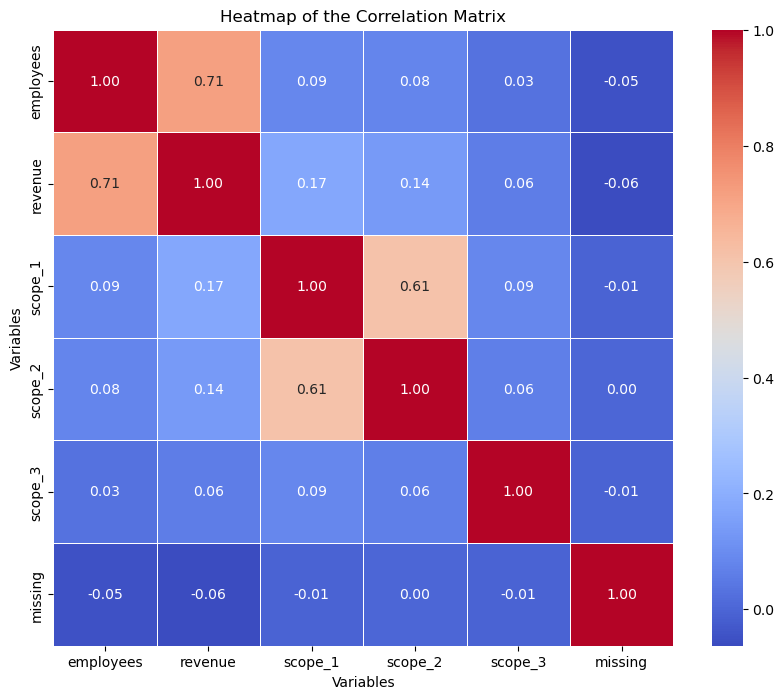

Top 10 Correlated Variables with highest absolute correlation with 'missing':
                         Variable  Correlation with missing  \
0       hq_country_United Kingdom                 -0.218913   
1                   region_Europe                 -0.193395   
2           region_Asia / Pacific                  0.107549   
3                hq_country_Spain                 -0.102673   
4                hq_country_China                  0.066475   
5                         revenue                 -0.062693   
6  water_consumption_per_employee                 -0.060108   
7                       employees                 -0.049331   
8               hq_country_France                 -0.045801   
9             hq_country_Portugal                 -0.041345   

   Absolute Correlation with missing  
0                           0.218913  
1                           0.193395  
2                           0.107549  
3                           0.102673  
4                           0.066

In [63]:
X = imp_data[[ 'employees', 'revenue',
                               'scope_1','scope_2', 'scope_3', 
                                'missing']]

X = X.astype(float)

# Apply scaling to the entire DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_transformed = pd.DataFrame(X_scaled, columns=X.columns)


# Compute the covariance matrix
corr_matrix = X_transformed.corr()

# Set figure size
plt.figure(figsize=(10, 8))

# Create a heatmap of the covariance matrix
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Set axis labels
plt.xlabel('Variables')
plt.ylabel('Variables')

# Set title
plt.title('Heatmap of the Correlation Matrix')

# Show the plot
plt.show()

imp_data['waste_production_per_employee'] = imp_data['waste_production'] / imp_data['employees']
imp_data['waste_recycling_per_employee'] = imp_data['waste_recycling'] / imp_data['employees']
imp_data['scope_1_per_employee'] = imp_data['scope_1'] / imp_data['employees']
imp_data['scope_2_per_employee'] = imp_data['scope_2'] / imp_data['employees']
imp_data['scope_3_per_employee'] = imp_data['scope_3'] / imp_data['employees']
imp_data['water_consumption_per_employee'] = imp_data['water_consumption'] / imp_data['employees']
imp_data['water_withdrawal_per_employee'] = imp_data['water_withdrawal'] / imp_data['employees']
imp_data['energy_consumption_per_employee'] = imp_data['energy_consumption'] / imp_data['employees']
imp_data['hours_of_training_per_employee'] = imp_data['hours_of_training'] / imp_data['employees']

X = imp_data[['secteur', 'region', 'hq_country', 'employees',
 'revenue', 'scope_1_per_employee', 'scope_2_per_employee', 'scope_3_per_employee', 'waste_production_per_employee', 
 'waste_recycling_per_employee', 'water_consumption_per_employee', 'water_withdrawal_per_employee', 
              'energy_consumption_per_employee', 'hours_of_training_per_employee', 
              'independent_board_members_percentage', 'legal_costs_paid_for_controversies',
 'ceo_compensation', 'missing']]


X = pd.get_dummies(X, columns=['region', 'hq_country', 'secteur'], drop_first=True)

# Ensuring that categorical variables are encoded as integers
region_columns = [col for col in X.columns if col.startswith('region') or col.startswith('secteur')
                 or col.startswith('hq_country')]
X[region_columns] = X[region_columns].astype(float)

X = X.astype(float)

# Apply scaling to the entire DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_transformed = pd.DataFrame(X_scaled, columns=X.columns)


# Compute the covariance matrix
corr_matrix = X_transformed.corr()

correlation_with_missing = corr_matrix['missing'].abs().sort_values(ascending=False)

# Select the top 10 correlated variables with highest absolute correlation
top_10_correlated = correlation_with_missing[1:11]  # Exclude 'missing' itself

# Create a DataFrame to hold the top 10 correlated variables with both absolute and non-absolute correlation values
top_10_correlated_df = pd.DataFrame({
    'Variable': top_10_correlated.index,
    'Correlation with missing': corr_matrix['missing'][top_10_correlated.index].values,
    'Absolute Correlation with missing': top_10_correlated.values
})

# Print the DataFrame
print("Top 10 Correlated Variables with highest absolute correlation with 'missing':")
print(top_10_correlated_df)

# Explication taille + localisation Europe/asie sans secteur particulier semble apparaitre
# Plus de divulgation en Europe / - en Asie
# Plus de divulgation quand taille augmente
# Plus de divulgation associé également à water recycling

# Regression de missing sur les variables explicatives

In [48]:
from scipy.stats.mstats import winsorize

imp_data['region_corrected'] = imp_data['region']
imp_data.loc[imp_data['hq_country'] == 'China', 'region_corrected'] = 'China'
imp_data.loc[imp_data['region_corrected'] == 'Asia / Pacific', 'region_corrected'] = 'Asia / Pacific without China'

# Filtre les données pour enlever les entreprises trop petites qui ont potentiellement des carac
# très dif des multinationales étudiées
quantile_05 = imp_data['employees'].quantile(0.05)
filtered_data = imp_data[imp_data['employees'] > quantile_05]

X = filtered_data[['revenue', 'employees', 'region_corrected','secteur']]

X = pd.get_dummies(X, columns=['region_corrected','secteur'])


# Convert variables starting with "region" to integers
region_columns = [col for col in X.columns if col.startswith('region_corrected') or col.startswith('secteur')]
X[region_columns] = X[region_columns].astype(int)

# Selectionne la catégorie de référence
X.drop(columns='region_corrected_United States and Canada', inplace=True)
X.drop(columns='secteur_Financials', inplace=True)


# Add constant to independent variables
X = sm.add_constant(X)
y = filtered_data['missing']

# Fit LPM
model = sm.OLS(y, X,missing ="drop").fit()
robust_model = model.get_robustcov_results(cov_type='HC1')
print(robust_model.summary())

# Fit Logit model
logit_model = sm.Logit(y, X, missing="drop").fit()
margeff = logit_model.get_margeff()
print(margeff.summary())

# On retrouve des effets marginaux moyens cohérents avec la LPM 
# Que les données soient filtrées ou pas -> meme resultats


                            OLS Regression Results                            
Dep. Variable:                missing   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     22.76
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           3.10e-75
Time:                        13:08:16   Log-Likelihood:                 24511.
No. Observations:               31109   AIC:                        -4.898e+04
Df Residuals:                   31090   BIC:                        -4.883e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [61]:
# varia sociales potentiellement reliées : 
# Hours of training per employee 
# ceo compensation

# varia ecolo potentiellement reliées :
# scope 1/2/3

# Winsorizing variables that have outliers
imp_data['winsorized_hours_of_training_per_employee'] = winsorize(imp_data['hours_of_training_per_employee'], limits=[0.05, 0.05])
imp_data["winsorized_ceo_compensation"] = winsorize(imp_data['ceo_compensation'], limits=[0.05, 0.05])

#X = imp_data[['hours_of_training_per_employee','ceo_compensation','scope_1','scope_2',
#              'scope_3','revenue', 'employees','region_corrected','secteur']]

#X = imp_data[['winsorized_hours_of_training_per_employee','winsorized_ceo_compensation',
#              'revenue', 'employees','region_corrected','secteur']]

X = imp_data[['winsorized_hours_of_training_per_employee','scope_1_per_employee','scope_2_per_employee',
              'scope_3_per_employee','revenue', 'employees','region_corrected','secteur',
             "water_consumption_per_employee"]]


X = pd.get_dummies(X, columns=['region_corrected','secteur'])
# Convert variables starting with "region" to integers
region_columns = [col for col in X.columns if col.startswith('region_corrected') or col.startswith('secteur')]
X[region_columns] = X[region_columns].astype(int)

# Selectionne la catégorie de référence
X.drop(columns='region_corrected_United States and Canada', inplace=True)
X.drop(columns='secteur_Financials', inplace=True)

# Add constant to independent variables
X = sm.add_constant(X)
y = imp_data['missing']

# Fit regression model
model = sm.OLS(y, X,missing ="drop").fit()
robust_model = model.get_robustcov_results(cov_type='HC1')
print(robust_model.summary())


# Effets marginaux sont modifiés MAIS reste quand meme avec les memes conclusions -> ajout de ceo_compensation fait
# completement foirer la reg meme si je winsorise

# Peut-on interpréter la relation avec water consumption???

# Pas de relation significative qui apparait entre les emissions (scope par employee) et
# le fait de relever les ecarts de salaires 

# Pas de relation significative à 10% egalement avec le nombre d'heures de formations proposées 
# (différentes dimensiosn sociales)

                            OLS Regression Results                            
Dep. Variable:                missing   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     10.43
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           9.16e-36
Time:                        13:29:26   Log-Likelihood:                -222.24
No. Observations:                2175   AIC:                             492.5
Df Residuals:                    2151   BIC:                             628.9
Df Model:                          23                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

# Matrice de correlation des emissions

Correlation Matrix:
          scope_1   scope_2   scope_3
scope_1  1.000000  0.605745  0.085535
scope_2  0.605745  1.000000  0.062567
scope_3  0.085535  0.062567  1.000000


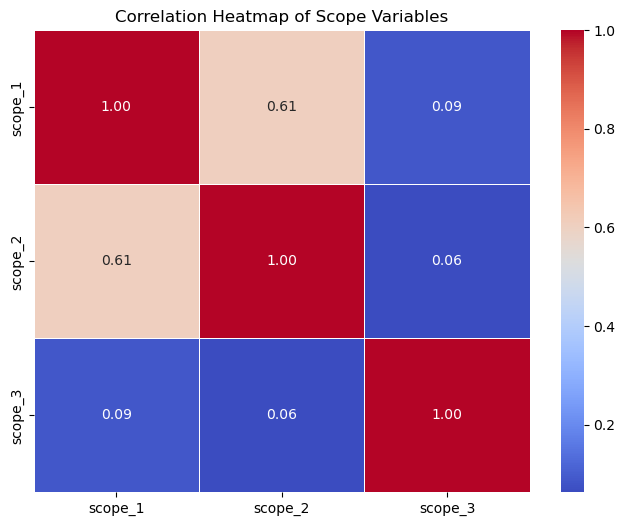

In [42]:
scope_columns = ['scope_1', 'scope_2', 'scope_3']

# Calculate the correlation matrix
correlation_matrix = imp_data[scope_columns].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Scope Variables')
plt.show()

# Correlation forte mais pas de 1 entre les 3 scopes !! Fouiller le scope 3

# Analyse en composante principales (ACP) pour faire ressortir les principales variables discriminantes

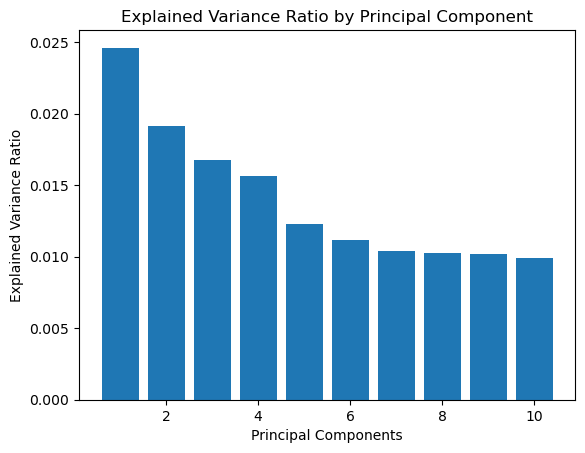

Top 10 Loading Vectors for PC1 (arranged by importance):
                            Variable   Loading  Absolute_Loading
7              region_Asia / Pacific -0.548031          0.548031
10   region_United States and Canada  0.415646          0.415646
109         hq_country_United States  0.391159          0.391159
26                  hq_country_China -0.350363          0.350363
8                      region_Europe  0.234889          0.234889
115               secteur_Financials  0.126119          0.126119
1                            revenue  0.123709          0.123709
23                 hq_country_Canada  0.113522          0.113522
54                  hq_country_Japan -0.108902          0.108902
0                          employees  0.106112          0.106112


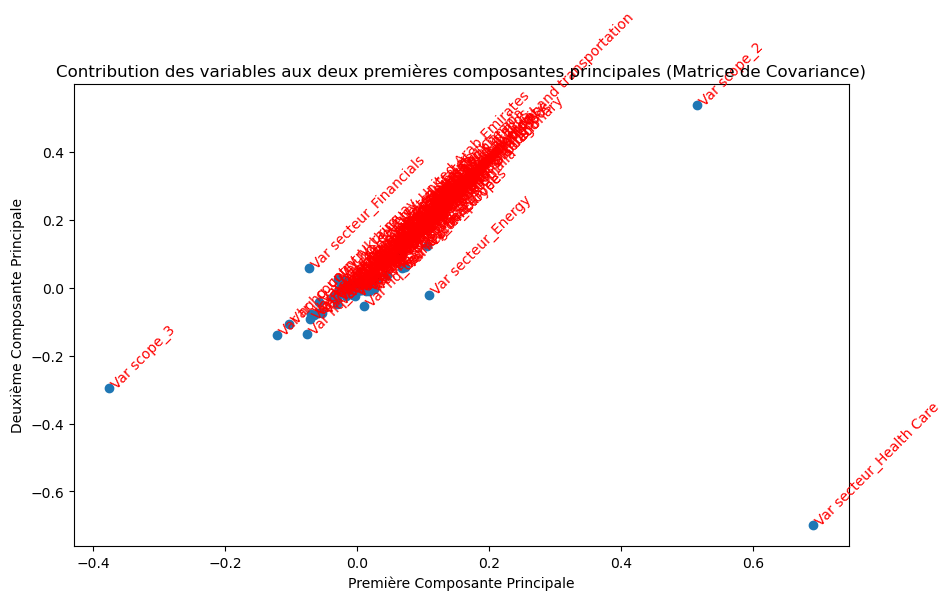

In [18]:
# Importing necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Selecting relevant features for PCA
X = imp_data[['secteur','region', 'hq_country', 'employees', 'revenue',
                               'scope_1','scope_2', 'scope_3', 
                                'hours_of_training','missing']]

# Converting categorical variables to dummy variables
X = pd.get_dummies(X, columns=['region', 'hq_country', 'secteur'], drop_first=True)

# Ensuring that categorical variables are encoded as integers
region_columns = [col for col in X.columns if col.startswith('region') or col.startswith('secteur')
                 or col.startswith('hq_country')]
X[region_columns] = X[region_columns].astype(int)

# Define columns for which you want to impute missing values with mean
columns_to_impute = ['scope_1', 'scope_2', 'scope_3', 'hours_of_training', 'employees', 'revenue']

# Apply imputation for specified columns
imputer = SimpleImputer(strategy='mean')
X[columns_to_impute] = imputer.fit_transform(X[columns_to_impute])

# Apply scaling to the entire DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame
X_transformed = pd.DataFrame(X_scaled, columns=X.columns)

# Dropping rows with missing values
X_transformed.dropna(inplace=True)

# Performing PCA
pca = PCA()
pca.fit(X_transformed)

# Plotting explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
plt.bar(range(1, 11), explained_variance_ratio[:10]) 
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

# Interpreting first principal component
first_pc  = pca.components_[0]

decomposition_first_pc = pd.DataFrame({'Variable': X_transformed.columns, 'Loading': first_pc})
decomposition_first_pc['Absolute_Loading'] = abs(decomposition_first_pc['Loading'])
decomposition_first_pc_sorted = decomposition_first_pc.sort_values(by='Absolute_Loading', ascending=False)
print("Top 10 Loading Vectors for PC1 (arranged by importance):")
print(decomposition_first_pc_sorted.head(10))

# Interpreting first two principal component

composantes_principales = pca.components_
first_pc = composantes_principales[:, 0]
second_pc = composantes_principales[:, 1]
variable_names = X_transformed.columns.tolist()


# Tracer le graphique de dispersion des deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(first_pc, second_pc)

# Annoter chaque point avec le nom de la variable
for i, variable in enumerate(variable_names):
    plt.annotate(f'Var {variable}', (first_pc[i], second_pc[i]), color='r', rotation=45)

# Ajouter des labels et un titre au graphique
plt.title('Contribution des variables aux deux premières composantes principales (Matrice de Covariance)')
plt.xlabel('Première Composante Principale')
plt.ylabel('Deuxième Composante Principale')

# Afficher le graphique
plt.show()

Le principe est simple : Il s’agit en fait de résumer l’information qui est contenue dans une large base de données en un certain nombre de variables synthétiques appelées : Composantes principales. 


0n retrouve que le market cap/ revenue /nb employés qui sont tous des proxy de la taille de l'entreprise contribuent nettement à expliquer la première composante principale et donc la variance au sein de la base de donnée.
